In [1]:
using Optim, LsqFit
using Plots, LaTeXStrings
using DelimitedFiles
using Statistics
using DataFrames
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
function print_fit_values(fit, par0, par_names)
    println(@sprintf "RSS = %.5f (convergence: %s)" sum(abs2, fit.resid) fit.converged)
    for i in 1:length(par0)
        name = par_names[i]
        val = fit.param[i]
        CIl = confidence_interval(fit, 0.05)[i][1]
        CIr = confidence_interval(fit, 0.05)[i][2]
        p0 = par0[i]
        println(@sprintf "  %s = %.3f (CI=(%.3f, %.3f), initial=%.3f)" name val CIl CIr p0)
    end
end

print_fit_values (generic function with 1 method)

# Viral load data fitting

Data for influenza from

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


## Data set

10 mice with 13 data points each

In [4]:
tdata = Array(range(0., 12. , step=1.0))
data = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')
DataFrame(data, Symbol.(0.:12.))

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,4.18551,5.67816,6.00515,5.9364,5.97712,5.44716,5.19848,4.00515,0.0,0.0,0.0,0.0
2,0.0,3.99136,5.47712,5.84488,5.82436,5.81012,5.0874,4.49136,0.0,0.0,0.0,0.0,0.0
3,0.0,3.49136,5.44716,5.81012,5.83815,5.78016,5.2954,5.01851,2.94716,0.0,0.0,0.0,0.0
4,0.0,3.29788,5.77233,6.24612,5.49136,5.9624,5.14412,5.51851,3.23882,0.0,0.0,0.0,0.0
5,0.0,4.75515,5.9624,6.44716,5.78016,5.83244,5.99136,4.96982,0.0,0.0,0.0,0.0,0.0
6,0.0,4.30151,5.49136,6.86448,5.70812,5.80282,4.9624,4.47712,0.0,0.0,0.0,0.0,0.0
7,0.0,3.49136,5.7954,5.74951,6.03148,5.82436,5.2954,5.17215,3.26036,0.0,0.0,0.0,0.0
8,0.0,4.00515,6.03148,5.83815,6.26036,6.1294,5.18551,4.83815,0.0,0.0,0.0,0.0,0.0
9,0.0,3.49136,6.18551,5.78784,5.59921,5.97712,5.34488,5.47712,0.0,0.0,0.0,0.0,0.0


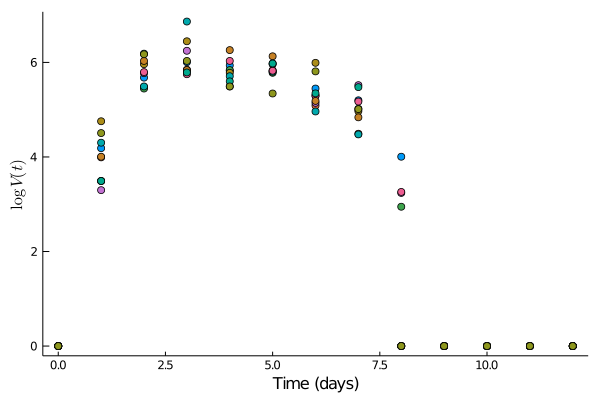

In [5]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[i, :], seriestype=:scatter) for i in 1:size(data, 1)]
plt

### Average of data

In [6]:
vdata_avg = mean(data, dims=1)[:]
vdata_std = std(data, dims=1)[:];

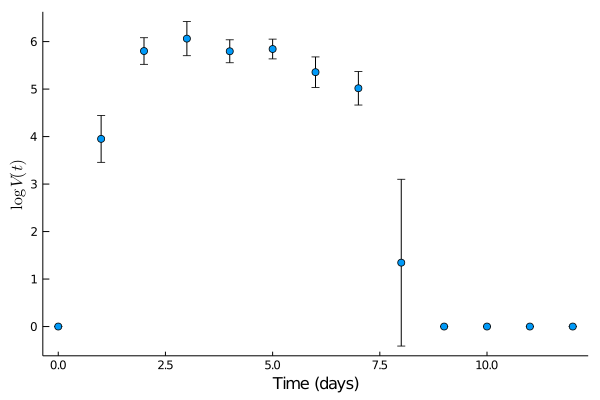

In [7]:
plot(tdata, vdata_avg, yerrors=vdata_std,
    seriestype=:scatter, legend=:none, grid=:off,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

### Combined data

In [8]:
ttdata = reshape(repeat(tdata', 10), 1, :)[:]
vvdata = reshape(data, 1, :)[:];

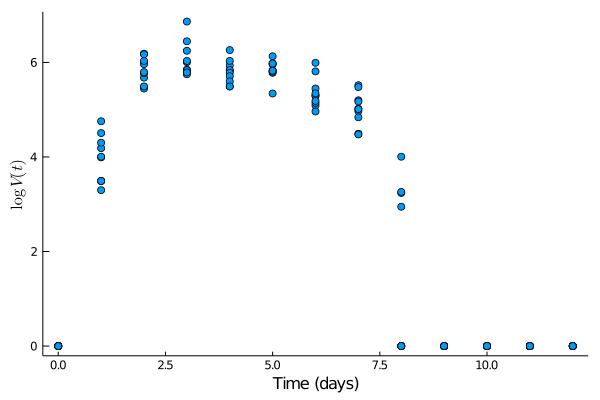

In [9]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

### Combined data omitting last 3 observations

In [10]:
ttdata = reshape(repeat(tdata[1:end-3]', 10), 1, :)[:]
tend = ttdata[end]
vvdata = reshape(data[:, 1:end-3], 1, :)[:];

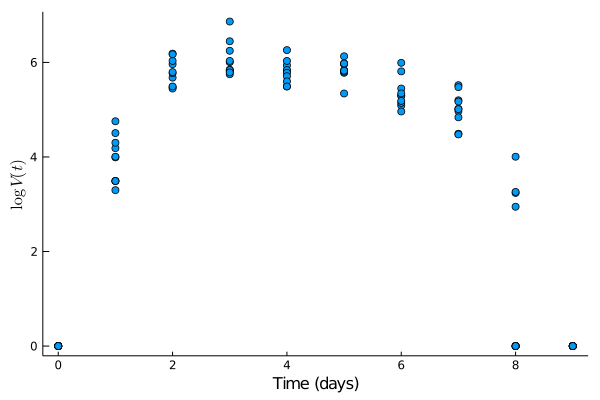

In [11]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

We'll use the combined data. But the average data shows similar results.

## Standard virus load function

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

### Chanlenges fitting this function

- The parameter $V_{\min}$ is particularly difficult to deal with because is smaller than reasonable steps length, causing $v_3(t)$ to become negative.

  Solutions to this problem:

  - Fix the value of $V_{\min}$.
  - Rescale $V_{\min}$, i.e., $V_{\min} = 10^{\tilde V_{\min}}$. **Implemented here.**
  - Restrict the step length, but convergence would take much longer. This could be done via `LineSearches.jl`.


- A similar issue occurs with $V_{\max}$, the scale is this parameter is very large compared to the rest.
  
  Solutions to this problem:
  
  - Fix the value of $V_{\max}$.
  - Rescale $V_{\max}$, i.e., $V_{\max} = 10^{\tilde V_{\min}}$. **Implemented here.**
  - Include weights. This could be done via `LsqFit.jl`


- The initial guess and lower and upper bounds are tricky to choose. First, because far from initial conditions we could have violation of $a_1<a_2<b_1<b_2$, hence negative $V(t)$; and second, if we impose bounds forcing this condition it is easy to hit the bounds when optimizing.


- Standard error are somehow large at the minimum.

**Using the rescaling $V_{\min}$ and $V_{\max}$ seems to be the better solution for the three problems above.**



In [12]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
v₁(t, a₁, a₂, logVmax) = 1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
v₂(t, a₂, α) = 1. - heaviside(t - a₂) + heaviside(t - a₂)*exp(-α*(t - a₂))
v₃(t, b₁, b₂, logVmin) = 1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
function ViralLoad(t, p)
    a₁, a₂, b₁, b₂, α, logVmin, logVmax = p
    log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
end
par_names = ["a₁", "a₂", "b₁", "b₂", "α", "logVmin", "logVmax"];

## Optimizations methods

### Levenberg-Marquardt via `LsqFit.jl`
It is particularly hard to choose initial values and lower and upper bounds

In [13]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmin, logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, -6.0,   5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, -7.0,    4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, -2.0,    7.0]
fit = curve_fit(ViralLoad, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.7722335746981689, 3.1612170949730154, 6.384718575867902, 7.720169784701113, 0.5032094939617314, -4.791506847093504, 6.066868539598038], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -5.676253474316009e-7, -5.676253474316009e-7, -5.676253474316009e-7, -5.676253474316009e-7, -5.676253474316009e-7, -5.676253474316009e-7, -5.676253474316009e-7, -5.676253474316009e-7, -5.676253474316009e-7, -5.676253474316009e-7], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0001479065617766825 0.21850497531793062 … 0.9984490182926804 0.9999999999541409; 0.0001479065617766825 0.21850497531793062 … 0.9984490182926804 0.9999999999541409], true, Float64[])

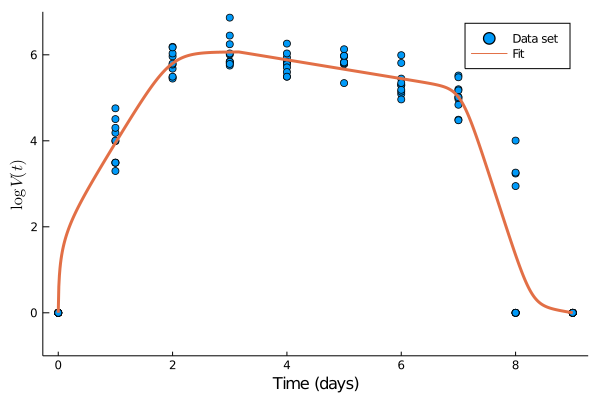

In [14]:
tt = [range(0., tend, step=1e-2);]
vv = ViralLoad(tt, fit.param)
pt = plot(ttdata, vvdata, 
    label="Data set", seriestype=:scatter)
plot!(pt, tt, vv, lw=3,
    grid=:off, label="Fit",
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
savefig(figdir*"Smith2018DataFit.png")
savefig(figdir*"Smith2018DataFit.pdf")
display(pt)

In [15]:
print_fit_values(fit, par0, par_names)

RSS = 35.26169 (convergence: true)
  a₁ = 0.772 (CI=(0.506, 1.038), initial=0.700)
  a₂ = 3.161 (CI=(2.292, 4.031), initial=2.880)
  b₁ = 6.385 (CI=(5.769, 7.000), initial=6.000)
  b₂ = 7.720 (CI=(7.471, 7.969), initial=7.600)
  α = 0.503 (CI=(0.016, 0.990), initial=0.200)
  logVmin = -4.792 (CI=(-5.792, -3.791), initial=-6.000)
  logVmax = 6.067 (CI=(5.778, 6.356), initial=5.000)


### Box constrains with Conjugate Gradient via `Optim.jl` 

In [16]:
res(p) = sum(abs2, ViralLoad(ttdata, p) - vvdata)

res (generic function with 1 method)

Convergence is faster and appears to be slightly better (smaller RSS) that with the previous method.

In [17]:
fit2 = optimize(res, par0, NelderMead())

 * Status: success

 * Candidate solution
    Final objective value:     3.526169e+01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    504
    f(x) calls:    854


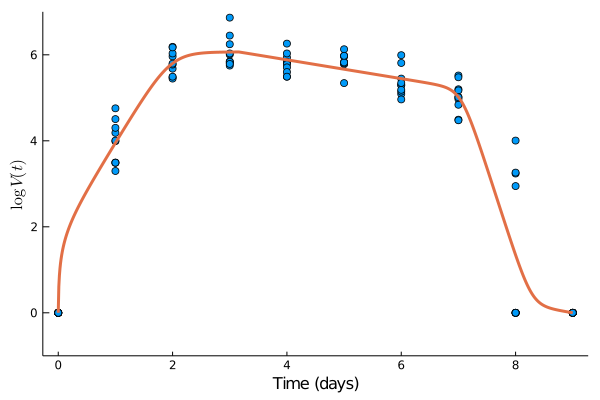

In [18]:
tt = [range(0., tend, step=1e-2);]
vv = ViralLoad(tt, Optim.minimizer(fit2))
plot(ttdata, vvdata, seriestype=:scatter)
plot!(tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

Same minima as before

In [19]:
Optim.minimizer(fit2)

7-element Array{Float64,1}:
  0.772240338011963
  3.161224460830618
  6.384742494207768
  7.720179652676609
  0.5032294338862253
 -4.791483620264046
  6.0668791294149935

**No standard error implemented. Compute manually.**

### Combined data including only the middle data points

In [20]:
ttdata = reshape(repeat(tdata[3:end-5]', 10), 1, :)[:]
vvdata = reshape(data[:, 3:end-5], 1, :)[:];

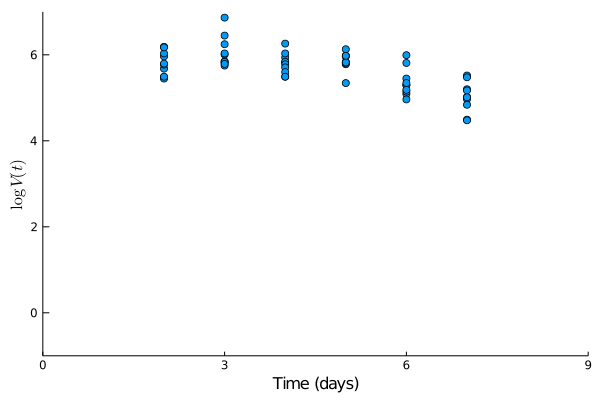

In [21]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xaxis=("Time (days)", (0, 9)), yaxis=(L"\log\,V(t)", (-1, 7)))

In [22]:
function ViralLoad2(t, p)
    a₁, _, b₁, b₂, _, logVmin, logVmax = fit.param
    a₂, α = p
    log10.(v₁.(t, a₁, a₂, logVmax).*v₂.(t, a₂, α).*v₃.(t, b₁, b₂, logVmin))
end

ViralLoad2 (generic function with 1 method)

Start from the same initial guess as before, however the fixed parameters are equal to the best estimate found above.

In [23]:
#       a₂,   α
par0 = [2.88, 0.20]
lb   = [1.00, 1e-8]
ub   = [5.00, 1e+2]
fit3 = curve_fit(ViralLoad2, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([3.161084589553707, 0.5031834101330305], [0.12248518834984967, 0.32352518834984956, 0.35348518834984954, 0.028315188349849585, -0.16175481165014993, 0.3092851883498495, 0.005245188349849883, -0.2308348116501504, -0.3848648116501501, -0.3715048116501505  …  -0.1811920694675475, 0.5259279305324522, -0.0012220694675475485, -0.5012220694675475, 0.04746793053245213, 0.5401679305324523, -0.15486206946754777, 0.17913793053245275, -0.45983206946754773, 0.005407930532452809], [-0.5139022796028729 0.0; -0.5139022796028729 0.0; … ; 0.2184936509617375 -1.6672197792652632; 0.2184936509617375 -1.6672197792652632], true, Float64[])

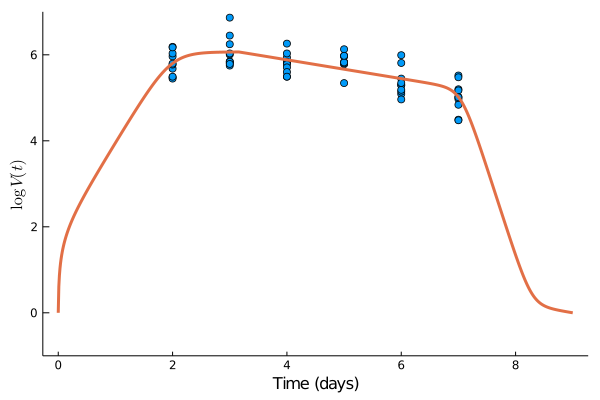

In [24]:
tt = [range(0., 9., step=1e-2);]
vv = ViralLoad2(tt, fit3.param)
plot(ttdata, vvdata, seriestype=:scatter)
plot!(tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [25]:
print_fit_values(fit3, par0, par_names[[2,5]])

RSS = 5.31255 (convergence: true)
  a₂ = 3.161 (CI=(2.811, 3.511), initial=2.880)
  α = 0.503 (CI=(0.398, 0.608), initial=0.200)


Same best estimates as if we have all the parameters free to estimate.

### Combined data with all data points (including traling zeros)

In [26]:
ttdata = reshape(repeat(tdata', 10), 1, :)[:]
tend = ttdata[end]
vvdata = reshape(data, 1, :)[:];

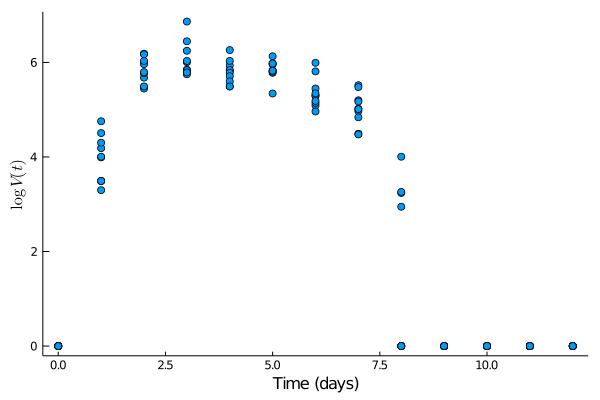

In [27]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xaxis=("Time (days)"), yaxis=(L"\log\,V(t)"))

Same initial conditions as in the first case

In [28]:
#       a₁,   a₂,   b₁,   b₂,   α,    logVmin, logVmax
par0 = [0.70, 2.88, 6.00, 7.60, 0.20, -6.0,   5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, -7.0,    4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, -2.0,    7.0]
fit = curve_fit(ViralLoad, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.7405354398321072, 2.8819864849139107, 6.225806542536902, 7.605615895387476, 0.23801131362470987, -5.144558541019433, 5.93190743803818], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -0.15516978215129573, -0.15516978215129573, -0.15516978215129573, -0.15516978215129573, -0.15516978215129573, -0.15516978215129573, -0.15516978215129573, -0.15516978215129573, -0.15516978215129573, -0.15516978215129573], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0001280134819485092 0.10333410667034924 … 1.0000000182948983 0.9999999999605389; 0.0001280134819485092 0.10333410667034924 … 1.0000000182948983 0.9999999999605389], true, Float64[])

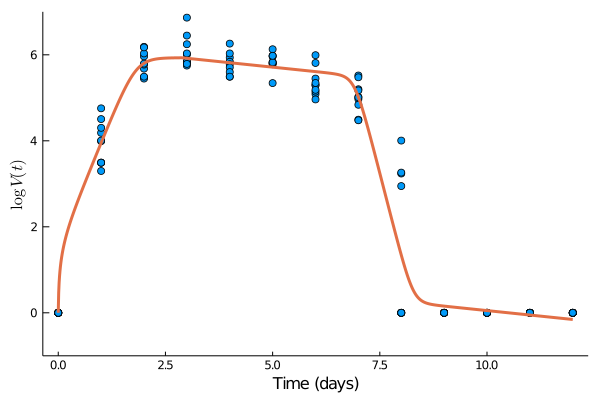

In [29]:
tt = [range(0., tend, step=1e-2);]
vv = ViralLoad(tt, fit.param)
plot(ttdata, vvdata, seriestype=:scatter)
plot!(tt, vv, lw=3,
    legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [30]:
print_fit_values(fit, par0, par_names)

RSS = 36.34237 (convergence: true)
  a₁ = 0.741 (CI=(0.504, 0.977), initial=0.700)
  a₂ = 2.882 (CI=(1.925, 3.839), initial=2.880)
  b₁ = 6.226 (CI=(5.939, 6.512), initial=6.000)
  b₂ = 7.606 (CI=(7.468, 7.743), initial=7.600)
  α = 0.238 (CI=(-0.010, 0.486), initial=0.200)
  logVmin = -5.145 (CI=(-5.835, -4.454), initial=-6.000)
  logVmax = 5.932 (CI=(5.723, 6.141), initial=5.000)


Including tralling zeros affects the value of $\alpha$, which is smaller now, i.e. slower decay rate.